In [ ]:
!pip3 install bitsandbytes peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
def get_dataset():
  from datasets import load_dataset, DatasetDict

  # Load the full dataset (this may take time and space)
  ds = load_dataset("zacharielegault/PatchCamelyon")

  # Access the 'train' split – PatchCamelyon only has one 'train' split, no 'test'
  full_dataset = ds['train']
  total_len = len(full_dataset)  # Should be around 327,000+

  # Define index ranges
  train_indices = list(range(0, 750)) + list(range(131072, 131820))
  val_indices = list(range(750, 1000)) + list(range(131820, 132072))
  test_size = int(0.01 * total_len)
  test_indices = list(range(total_len - test_size, total_len))  # last 1%

  # Apply slicing using `select`
  train_dataset = full_dataset.select(train_indices)
  val_dataset = full_dataset.select(val_indices)
  test_dataset = full_dataset.select(test_indices)

  # Optional: Bundle as a DatasetDict
  custom_splits = DatasetDict({
      "train": train_dataset,
      "validation": val_dataset,
      "test": test_dataset
  })
  return custom_splits

In [ ]:
def get_test_dataset():
  from datasets import load_dataset, DatasetDict

  # Load the full dataset (this may take time and space)
  ds = load_dataset("zacharielegault/PatchCamelyon")

  # Access the 'train' split – PatchCamelyon only has one 'train' split, no 'test'
  full_dataset = ds['test']
  total_len = len(full_dataset)  # Should be around 26,000+

  # Define index ranges
  test_indices = list(range(0, 150)) + list(range(20000, 20150))

  # Apply slicing using `select`
  test_dataset = full_dataset.select(test_indices)

  # Optional: Bundle as a DatasetDict
  custom_splits = DatasetDict({
      "test": test_dataset
  })
  return custom_splits

In [ ]:
test_dataset = get_test_dataset()["test"]

In [ ]:
ds = get_dataset()
ds["train"][0]

train-00001-of-00003.parquet:  96%|#########6| 357M/370M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/140M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/136M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/262144 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/32768 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/32768 [00:00<?, ? examples/s]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 0}

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

# Load the BLIP model and processor (do this only once)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model.eval()

# If GPU is available, use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_blipcaption(example):
    """
    Given a dictionary with 'image': PIL.Image and 'label': int,
    return the caption string generated by BLIP.
    """
    image = example['image']
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = model.generate(**inputs)

    caption = processor.decode(output_ids[0], skip_special_tokens=True)
    return {
        "image": example["image"],
        "label": example["label"],
        "caption": caption
    }



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
test_dataset = ds['test']
test_dataset[0]

In [ ]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 300
})

In [ ]:
def caption_test_data(test_dataset):
  test_dataset = test_dataset.map(get_blipcaption, batched=False)
  return test_dataset
test_dataset = caption_test_data(test_dataset)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
test_dataset

Dataset({
    features: ['image', 'label', 'caption'],
    num_rows: 300
})

In [ ]:
# === Run captioning on all splits ===
def caption_all_splits(dataset_dict):
    new_dataset = DatasetDict()
    for split in dataset_dict:
        print(f"Generating captions for split: {split}")
        new_dataset[split] = dataset_dict[split].map(add_caption, batched=False)
    return new_dataset

# === Run the thing ===
captioned_dataset = caption_all_splits(custom_splits)

Generating captions for split: train


Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Generating captions for split: validation


Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Generating captions for split: test


Map:   0%|          | 0/2621 [00:00<?, ? examples/s]

In [ ]:
captioned_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'caption'],
        num_rows: 1498
    })
    validation: Dataset({
        features: ['image', 'label', 'caption'],
        num_rows: 502
    })
    test: Dataset({
        features: ['image', 'label', 'caption'],
        num_rows: 2621
    })
})

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from trl import SFTConfig, SFTTrainer

import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

MODEL_ID = "Qwen/Qwen2-VL-7B-Instruct"
EPOCHS = 1
BATCH_SIZE = 1
GRADIENT_CHECKPOINTING = True,  # Tradeoff between memory efficiency and computation time.
USE_REENTRANT = False,
OPTIM = "paged_adamw_32bit"
LEARNING_RATE = 2e-5
LOGGING_STEPS = 50
EVAL_STEPS = 50
SAVE_STEPS = 50
EVAL_STRATEGY = "steps"
SAVE_STRATEGY = "steps"
METRIC_FOR_BEST_MODEL="eval_loss"
LOAD_BEST_MODEL_AT_END=True
MAX_GRAD_NORM = 1
WARMUP_STEPS = 0
DATASET_KWARGS={"skip_prepare_dataset": True} # We have to put for VLMs
REMOVE_UNUSED_COLUMNS = False # VLM thing
MAX_SEQ_LEN=1
NUM_STEPS = (283 // BATCH_SIZE) * EPOCHS
print(f"NUM_STEPS: {NUM_STEPS}")

Using device: cuda
NUM_STEPS: 283


In [ ]:
system_message = """You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images.
Your task is to process and extract if it is cancerous image or not,
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0."""

def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample["caption"] + "\nUsing the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.",
                },
            ],
        },
        # {
        #     "role": "assistant",
        #     "content": [{"type": "text", "text": sample["label"]}],
        # },
    ]

In [ ]:

train_dataset, eval_dataset, test_dataset = captioned_dataset['train'], captioned_dataset['validation'], captioned_dataset['test']

In [ ]:
print(len(train_dataset))
print("-"*30)
print(train_dataset)
print("-"*30)
print(train_dataset[0])
print("-"*30)
train_dataset, eval_dataset, test_dataset = captioned_dataset['train'], captioned_dataset['validation'], captioned_dataset['test']
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

print(len(train_dataset))
print("-"*30)
print(train_dataset[0])
print("-"*30)
print(len(test_dataset))
print("-"*30)
print(test_dataset[0])

1498
------------------------------
Dataset({
    features: ['image', 'label', 'caption'],
    num_rows: 1498
})
------------------------------
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x79932A3B3D90>, 'label': 0, 'caption': 'purple glitter con con con con con con con con con con con con con con con con con con'}
------------------------------
1498
------------------------------
[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. \nYour task is to process and extract if it is cancerous image or not, \nleveraging multimodal understanding to provide accurate and contextually relevant information.\nReturn 1 if there is cancer tumour, 0 if not.\nReturn 1 or 0.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x79932A3B2B10>}, {'type': 'text', 'text': "purple glitter con con 

a close up of a pink granite counter
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.
1


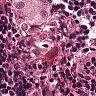

In [ ]:
sample_data = test_dataset[0]
sample_question = test_dataset[0][1]["content"][1]["text"]
sample_answer = test_dataset[0][2]["content"][0]["text"]
sample_image = test_dataset[0][1]["content"][0]["image"]

print(sample_question)
print(sample_answer)
sample_image

In [ ]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        quantization_config=bnb_config,
        use_cache=False
        )

else:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        use_cache=False
        )

processor = Qwen2VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
def text_generator(sample_data):
    text = processor.apply_chat_template(
        sample_data[0:2], tokenize=False, add_generation_prompt=True
    )

    print(f"Prompt: {text}")
    print("-"*30)

    image_inputs = sample_data[1]["content"][0]["image"]

    inputs = processor(
        text=[text],
        images = image_inputs,
        return_tensors="pt"
    )
    inputs = inputs.to(device)

    generated_ids = model.generate(**inputs, max_new_tokens=MAX_SEQ_LEN)

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True
    )
    del inputs
    actual_answer = sample_data[2]["content"][0]["text"]
    import re
    match = re.search(r"\d(?!.*\d)", output_text[0])
    last_digit = match.group(0) if match else "?"

    return last_digit, actual_answer


generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a pink granite counter
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Generated Answer: 0
Actual Answer: 1


In [ ]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

print(f"Before adapter parameters: {model.num_parameters()}")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters() # After LoRA trainable parameters increases. Since we add adapter.

Before adapter parameters: 8291375616
trainable params: 2,523,136 || all params: 8,293,898,752 || trainable%: 0.0304


In [ ]:
training_args = SFTConfig(
    output_dir="./output",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    learning_rate=LEARNING_RATE,
    logging_steps=LOGGING_STEPS,
    eval_steps=EVAL_STEPS,
    eval_strategy=EVAL_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    max_grad_norm=MAX_GRAD_NORM,
    warmup_steps=WARMUP_STEPS,
    dataset_kwargs=DATASET_KWARGS,
    max_seq_length=MAX_SEQ_LEN,
    remove_unused_columns = REMOVE_UNUSED_COLUMNS,
    optim=OPTIM,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
def tokenize_and_mask(example):
    prompt = processor.apply_chat_template(example["content"], tokenize=False)
    image = example["image"]

    # Tokenize text and image
    encoded = processor(text=prompt, images=image, return_tensors="pt", padding="max_length", truncation=True, max_length=512)

    # Create labels: same as input_ids, except pad tokens = -100
    input_ids = encoded["input_ids"][0]
    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100

    # Force label token to be the last one ("0" or "1")
    target_token = processor.tokenizer(str(example["label"]), add_special_tokens=False)["input_ids"]
    if len(target_token) != 1:
        raise ValueError(f"Label {example['label']} is not a single token")

    labels[-1] = target_token[0]  # overwrite last position with target
    return {
        "input_ids": input_ids,
        "attention_mask": encoded["attention_mask"][0],
        "pixel_values": encoded["pixel_values"][0],
        "labels": labels
    }


In [ ]:
collate_sample = [train_dataset[0], train_dataset[1]] # for batch size 2.

def collate_fn(batch):
  return {
       "input_ids": torch.stack([ex["input_ids"] for ex in batch]),
        "attention_mask": torch.stack([ex["attention_mask"] for ex in batch]),
        "pixel_values": torch.stack([ex["pixel_values"] for ex in batch]),
        "labels": torch.stack([ex["labels"] for ex in batch])}

collated_data = collate_fn(collate_sample)
print(collated_data.keys())  # dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'labels'])

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw', 'labels'])


In [ ]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 0,
 'caption': 'purple glitter con con con con con con con con con con con con con con con con con con'}

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,

)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
print("-"*30)
print("Initial Evaluation")
metric = trainer.evaluate()
print(metric)
print("-"*30)

print("Training")
trainer.train()
print("-"*30)

------------------------------
Initial Evaluation


{'eval_loss': 4.272802352905273, 'eval_model_preparation_time': 0.0041, 'eval_runtime': 90.7918, 'eval_samples_per_second': 5.529, 'eval_steps_per_second': 5.529}
------------------------------
Training


Step,Training Loss,Validation Loss,Model Preparation Time
50,4.151200,3.902993,0.004100
100,3.616800,3.272860,0.004100
150,2.870700,2.395175,0.004100
200,1.916600,1.474343,0.004100
250,1.248100,1.072410,0.004100
300,0.978200,0.935614,0.004100
350,0.916600,0.901972,0.004100
400,0.869800,0.880267,0.004100
450,0.890000,0.861952,0.004100
500,0.866400,0.850142,0.004100


------------------------------


In [ ]:
trainer.save_model(training_args.output_dir)

In [ ]:
test_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 0,
 'caption': 'imbauella cyosus, a type of the immune'}

In [ ]:
from tqdm import tqdm
import torch
import re

def extract_final_digit(text):
    match = re.search(r"[01](?!.*[01])", text.strip())
    return int(match.group(0)) if match else -1  # -1 = fallback for garbage outputs

def evaluate_model_on_test(test_dataset, processor, model):
    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")

    correct = 0
    total = 0

    for example in tqdm(test_dataset):
        # 1. Generate text prompt
        text = processor.apply_chat_template(
            example[0:2], tokenize=False, add_generation_prompt=True
        )

        print(f"Prompt: {text}")
        print("-"*30)

        image_inputs = example[1]["content"][0]["image"]

        inputs = processor(
            text=[text],
            images = image_inputs,
            return_tensors="pt"
        )
        inputs = inputs.to(device)

        generated_ids = model.generate(**inputs, max_new_tokens=MAX_SEQ_LEN)

        output_text = processor.batch_decode(
            generated_ids, skip_special_tokens=True
        )
        del inputs
        actual_answer = example[2]["label"]
        import re
        match = re.search(r"\d(?!.*\d)", output_text[0])
        last_digit = match.group(0) if match else "?"

        gold = example[2]["label"]
        print(f"Response: {last_digit}")
        print(f"Gold: {gold}")
        print("-"*30)
        if last_digit == gold:
            correct += 1
        total += 1

    accuracy = correct / total if total else 0
    return accuracy


In [ ]:
system_message = """You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images.
Your task is to process and extract if it is cancerous image or not,
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0."""

def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample["caption"] + "\nUsing the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.",
                },
            ],
        },
        {
            "label": sample["label"]
        }
    ]

In [ ]:
# train_dataset = [format_data(sample) for sample in train_dataset]
# eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]


In [ ]:
test_dataset

[[{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. \nYour task is to process and extract if it is cancerous image or not, \nleveraging multimodal understanding to provide accurate and contextually relevant information.\nReturn 1 if there is cancer tumour, 0 if not.\nReturn 1 or 0.'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>},
    {'type': 'text',
     'text': "imbauella cyosus, a type of the immune\nUsing the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise."}]},
  {'label': 0}],
 [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. \nYour task is to process and extract if it is cancerous image or not, \nleveraging 

In [ ]:
import gc
import time
gc.collect()
torch.cuda.empty_cache()

In [ ]:
test_dataset

[[{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. \nYour task is to process and extract if it is cancerous image or not, \nleveraging multimodal understanding to provide accurate and contextually relevant information.\nReturn 1 if there is cancer tumour, 0 if not.\nReturn 1 or 0.'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>},
    {'type': 'text',
     'text': "imbauella cyosus, a type of the immune\nUsing the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise."}]},
  {'label': 0}],
 [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. \nYour task is to process and extract if it is cancerous image or not, \nleveraging 

In [ ]:
from transformers import AutoTokenizer, AutoProcessor, AutoModelForCausalLM

# Load model if not already
model = Qwen2VLForConditionalGeneration.from_pretrained(training_args.output_dir)
processor = Qwen2VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"



Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauella cyosus, a type of the immune
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


  0%|          | 0/300 [00:00<?, ?it/s]


KeyError: 'content'

In [ ]:

accuracy = evaluate_model_on_test(test_dataset, processor, model)
print(f"Test Accuracy: {accuracy:.2%}")

  0%|          | 0/300 [00:00<?, ?it/s]

Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauella cyosus, a type of the immune
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


  1%|          | 2/300 [00:00<01:02,  4.77it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a pink glitter confection with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

  1%|▏         | 4/300 [00:00<00:58,  5.08it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>pink glitter glitter
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually

  2%|▏         | 6/300 [00:01<00:56,  5.19it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a red granite floor
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and

  3%|▎         | 8/300 [00:01<00:55,  5.25it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide 

  3%|▎         | 10/300 [00:01<00:55,  5.26it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with a small, circular, purple flower
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal und

  4%|▍         | 12/300 [00:02<00:54,  5.26it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a white background with purple and black spots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide

  5%|▍         | 14/300 [00:02<00:54,  5.28it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and black leopard print fabric
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accura

  5%|▌         | 16/300 [00:03<01:26,  3.28it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a granite counter top
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate a

  6%|▌         | 18/300 [00:04<01:09,  4.05it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple circle with a white circle in the middle
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

  7%|▋         | 20/300 [00:04<01:01,  4.59it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with a white circle
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

  7%|▋         | 22/300 [00:04<00:56,  4.90it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a red and black marble
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate 

  8%|▊         | 24/300 [00:05<00:54,  5.08it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with small stars
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate 

  9%|▊         | 26/300 [00:05<00:53,  5.15it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a white and purple granite counter top
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurat

  9%|▉         | 28/300 [00:06<01:19,  3.40it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a white and purple cell membrane
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and 

 10%|█         | 30/300 [00:06<01:05,  4.15it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images

 11%|█         | 32/300 [00:07<00:57,  4.65it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple leopard print fabric
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and con

 11%|█▏        | 34/300 [00:07<00:53,  4.94it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - imr antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to pr

 12%|█▏        | 36/300 [00:07<00:51,  5.11it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a red granite floor with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide ac

 13%|█▎        | 38/300 [00:08<00:50,  5.19it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images

 13%|█▎        | 40/300 [00:09<01:18,  3.29it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide 

 14%|█▍        | 42/300 [00:09<01:03,  4.07it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide 

 15%|█▍        | 44/300 [00:09<00:55,  4.60it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a purple and white marble
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accura

 15%|█▌        | 46/300 [00:10<00:51,  4.91it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - 1 antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task i

 16%|█▌        | 48/300 [00:10<00:49,  5.07it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white flower pattern on a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding t

 17%|█▋        | 50/300 [00:11<00:48,  5.15it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a pink flower on a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate a

 17%|█▋        | 52/300 [00:11<01:13,  3.39it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple granite floor with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide

 18%|█▊        | 54/300 [00:12<00:59,  4.12it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>purple glitter glitter fabric
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and con

 19%|█▊        | 56/300 [00:12<00:52,  4.66it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a purple granite
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and co

 19%|█▉        | 58/300 [00:13<00:49,  4.93it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a pink and white flower on a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide 

 20%|█▉        | 59/300 [00:13<00:47,  5.03it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a pink and white flower on a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 20%|██        | 61/300 [00:14<01:09,  3.46it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your

 21%|██        | 63/300 [00:14<00:56,  4.20it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images

 22%|██▏       | 65/300 [00:14<00:49,  4.70it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple flower on a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate

 22%|██▏       | 67/300 [00:15<00:46,  4.98it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with a white circle
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

 23%|██▎       | 68/300 [00:15<00:45,  5.05it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small stars
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 23%|██▎       | 70/300 [00:16<01:08,  3.35it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a white table with a pink flower on it
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurat

 24%|██▍       | 72/300 [00:16<00:55,  4.11it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a sample of the human blood in the human blood
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide

 25%|██▍       | 74/300 [00:17<00:48,  4.64it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images

 25%|██▌       | 76/300 [00:17<00:45,  4.96it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a pink and white marble tile
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide acc

 26%|██▌       | 78/300 [00:17<00:43,  5.14it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and black background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide 

 27%|██▋       | 80/300 [00:18<00:42,  5.22it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with a small amount of purple
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understandi

 27%|██▋       | 82/300 [00:19<01:02,  3.49it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and black glitter bow with a bow on the side
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to 

 28%|██▊       | 84/300 [00:19<00:51,  4.22it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imtaly - related imtaly - related imtaly - related imtaly - related
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal und

 29%|██▊       | 86/300 [00:19<00:45,  4.72it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide 

 29%|██▉       | 88/300 [00:20<00:42,  5.00it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a red and white marble
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate 

 30%|██▉       | 89/300 [00:20<00:41,  5.08it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 30%|███       | 91/300 [00:21<01:02,  3.34it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide 

 31%|███       | 93/300 [00:21<00:50,  4.12it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white polka dot print fabric
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accu

 32%|███▏      | 95/300 [00:22<00:44,  4.65it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a cell membrane with a cell membrane in the middle
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to pro

 32%|███▏      | 97/300 [00:22<00:40,  4.96it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with a small amount of purple
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understandi

 33%|███▎      | 99/300 [00:22<00:39,  5.09it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imtale - related cy - 1 antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accu

 34%|███▎      | 101/300 [00:23<00:38,  5.18it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauin antibody antibody antibody in the liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provid

 34%|███▍      | 103/300 [00:24<00:58,  3.38it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images

 35%|███▌      | 105/300 [00:24<00:47,  4.15it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>purple glitter fabric
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextuall

 36%|███▌      | 107/300 [00:24<00:41,  4.67it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with a small amount of purple
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understandi

 36%|███▋      | 109/300 [00:25<00:38,  4.96it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images

 37%|███▋      | 110/300 [00:25<00:37,  5.06it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imtalus in the liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 37%|███▋      | 112/300 [00:26<00:56,  3.32it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imtale stained stained stained stained stained stained stained stained stained stained stained stained stained stained stained stained stained
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to proc

 38%|███▊      | 114/300 [00:26<00:45,  4.10it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a white and pink flower pattern
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and c

 39%|███▊      | 116/300 [00:27<00:39,  4.64it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a pink marble tile with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide acc

 39%|███▉      | 118/300 [00:27<00:36,  4.95it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imtomic cancer - image of the breast
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate 

 40%|████      | 120/300 [00:27<00:35,  5.11it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple flower in a white vase
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and c

 41%|████      | 122/300 [00:28<00:34,  5.20it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white marble tile
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and co

 41%|████▏     | 124/300 [00:29<00:51,  3.45it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imethylylmetides, or imethylmetides, is a type of
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

 42%|████▏     | 126/300 [00:29<00:41,  4.20it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with a small amount of white dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to 

 43%|████▎     | 128/300 [00:29<00:36,  4.71it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images

 43%|████▎     | 130/300 [00:30<00:34,  4.99it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauel - imbauel - imbauel imbauel imbauel imbauel
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to pr

 44%|████▎     | 131/300 [00:30<00:33,  5.08it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with a pattern
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 44%|████▍     | 133/300 [00:31<00:48,  3.41it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - 1 antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task i

 45%|████▌     | 135/300 [00:31<00:39,  4.17it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauel - related imbauel - related imbauel imbauel imbauel im
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understa

 46%|████▌     | 137/300 [00:31<00:34,  4.69it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide 

 46%|████▋     | 139/300 [00:32<00:32,  4.98it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images

 47%|████▋     | 140/300 [00:32<00:31,  5.07it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a pink marble tile with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 47%|████▋     | 142/300 [00:33<00:47,  3.33it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imethylylmetides, or imethylmetides, is a type of
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

 48%|████▊     | 144/300 [00:33<00:37,  4.11it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauen antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Yo

 49%|████▊     | 146/300 [00:34<00:33,  4.62it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate a

 49%|████▉     | 148/300 [00:34<00:30,  4.94it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with small white dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accu

 50%|█████     | 150/300 [00:34<00:29,  5.07it/s]

Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 0
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate a

 51%|█████     | 152/300 [00:35<00:29,  5.09it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a cell is shown in the image
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and cont

 51%|█████▏    | 154/300 [00:36<00:44,  3.27it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - 1 antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task i

 52%|█████▏    | 156/300 [00:36<00:35,  4.05it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imercopys in the liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextual

 53%|█████▎    | 158/300 [00:36<00:30,  4.60it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imtalous cells in the liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and conte

 53%|█████▎    | 160/300 [00:37<00:28,  4.90it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imtalous muscle tissue in the liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate a

 54%|█████▍    | 162/300 [00:37<00:27,  5.06it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>purple glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your

 55%|█████▍    | 164/300 [00:38<00:26,  5.18it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple granite floor with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide

 55%|█████▌    | 166/300 [00:38<00:38,  3.45it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a purple granite
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and co

 56%|█████▌    | 168/300 [00:39<00:31,  4.19it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a red granite counter top
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and context

 57%|█████▋    | 170/300 [00:39<00:27,  4.69it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with small white dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accu

 57%|█████▋    | 172/300 [00:40<00:25,  4.97it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauin - imbauin antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and 

 58%|█████▊    | 173/300 [00:40<00:25,  5.06it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a red granite counter
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 58%|█████▊    | 175/300 [00:41<00:36,  3.39it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with a white and black spec
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provid

 59%|█████▉    | 177/300 [00:41<00:29,  4.16it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a sample of the human blood
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and conte

 60%|█████▉    | 179/300 [00:41<00:26,  4.65it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple granite floor with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide

 60%|██████    | 181/300 [00:42<00:23,  4.96it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>purple glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your

 61%|██████    | 183/300 [00:42<00:22,  5.11it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with a small amount of purple
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understandi

 62%|██████▏   | 185/300 [00:43<00:22,  5.19it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - 1 antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task i

 62%|██████▏   | 187/300 [00:43<00:34,  3.31it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white marble tile
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and co

 63%|██████▎   | 189/300 [00:44<00:27,  4.09it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a purple granite
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and co

 64%|██████▎   | 191/300 [00:44<00:23,  4.63it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imethylthythythythythythythythythythythythythythythythythy
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understandin

 64%|██████▍   | 193/300 [00:45<00:21,  4.94it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a sample of the human blood
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and conte

 65%|██████▍   | 194/300 [00:45<00:21,  5.03it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauel - related cyos in the liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 65%|██████▌   | 196/300 [00:46<00:30,  3.38it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with a pattern of small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understandin

 66%|██████▌   | 198/300 [00:46<00:24,  4.13it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imercy of the liver liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and context

 67%|██████▋   | 200/300 [00:46<00:21,  4.65it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - 1 antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task i

 67%|██████▋   | 202/300 [00:47<00:19,  4.96it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white marble tile
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and co

 68%|██████▊   | 203/300 [00:47<00:19,  5.06it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imercy of the liver, liver, liver, liver, liver, liver, liver, liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 68%|██████▊   | 205/300 [00:48<00:27,  3.44it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple substance with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide acc

 69%|██████▉   | 207/300 [00:48<00:22,  4.13it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide 

 70%|██████▉   | 209/300 [00:49<00:19,  4.66it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple granite floor with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide

 70%|███████   | 211/300 [00:49<00:18,  4.94it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a sample of the blood of a patient
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate an

 71%|███████   | 213/300 [00:49<00:17,  5.09it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauen in the liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually

 72%|███████▏  | 215/300 [00:50<00:16,  5.19it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a purple granite
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and co

 72%|███████▏  | 217/300 [00:51<00:24,  3.40it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small, irregular shapes
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understandin

 73%|███████▎  | 219/300 [00:51<00:19,  4.16it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple granite floor with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide

 74%|███████▎  | 221/300 [00:51<00:16,  4.67it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - i antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task i

 74%|███████▍  | 223/300 [00:52<00:15,  4.96it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small, irregular shapes
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understandin

 75%|███████▍  | 224/300 [00:52<00:15,  5.05it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple glitter background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 75%|███████▌  | 226/300 [00:53<00:21,  3.42it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>purple glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your

 76%|███████▌  | 228/300 [00:53<00:17,  4.17it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - 1 antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task i

 77%|███████▋  | 230/300 [00:54<00:14,  4.70it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide 

 77%|███████▋  | 232/300 [00:54<00:13,  5.00it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple marble floor with a white and red marble
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

 78%|███████▊  | 234/300 [00:54<00:12,  5.13it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is ca

 79%|███████▊  | 236/300 [00:55<00:12,  5.20it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imethylylmetides, or imethylmetides, is a type of
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

 79%|███████▉  | 238/300 [00:56<00:18,  3.37it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a pink granite floor
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate an

 80%|████████  | 240/300 [00:56<00:14,  4.14it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a pink granite counter top
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contex

 81%|████████  | 242/300 [00:56<00:12,  4.65it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauen in the liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually

 81%|████████▏ | 244/300 [00:57<00:11,  4.93it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>purple glitter glitter fabric
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and con

 82%|████████▏ | 245/300 [00:57<00:10,  5.03it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a cell membrane with a cell membrane in the middle
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 82%|████████▏ | 247/300 [00:58<00:15,  3.38it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauen - imbauen - imbauen imbauen imbauen imbauen
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to pr

 83%|████████▎ | 249/300 [00:58<00:12,  4.14it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and blue background with small squares
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provid

 84%|████████▎ | 251/300 [00:58<00:10,  4.67it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a white and purple marble tile
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide a

 84%|████████▍ | 253/300 [00:59<00:09,  4.96it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - 1 antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task i

 85%|████████▌ | 255/300 [00:59<00:08,  5.10it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imercy of the liver, stained by the liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accu

 86%|████████▌ | 257/300 [01:00<00:08,  5.20it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>purple glitter glitter fabric
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and con

 86%|████████▋ | 259/300 [01:00<00:12,  3.39it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with a small flower
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

 87%|████████▋ | 261/300 [01:01<00:09,  4.16it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate a

 88%|████████▊ | 263/300 [01:01<00:07,  4.68it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - 1 antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task i

 88%|████████▊ | 265/300 [01:02<00:07,  4.97it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple granite counter top
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and cont

 89%|████████▊ | 266/300 [01:02<00:06,  5.07it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 89%|████████▉ | 268/300 [01:03<00:09,  3.37it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imbauin - related cyos in the liver
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate a

 90%|█████████ | 270/300 [01:03<00:07,  4.14it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple granite with a white background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accur

 91%|█████████ | 272/300 [01:03<00:06,  4.66it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with a small amount of purple
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

 91%|█████████▏| 274/300 [01:04<00:05,  4.94it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white background with small purple hearts
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to

 92%|█████████▏| 276/300 [01:04<00:04,  5.12it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple and white marble background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate 

 93%|█████████▎| 278/300 [01:05<00:04,  5.20it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a white and purple heart shaped paper
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate

 93%|█████████▎| 280/300 [01:05<00:06,  3.33it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imr - 1 antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody antibody
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task i

 94%|█████████▍| 282/300 [01:06<00:04,  4.11it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>purple glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your

 95%|█████████▍| 284/300 [01:06<00:03,  4.65it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple glitter background
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and conte

 95%|█████████▌| 286/300 [01:07<00:02,  4.95it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>purple glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your

 96%|█████████▌| 287/300 [01:07<00:02,  5.03it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with a small amount of purple
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 96%|█████████▋| 289/300 [01:08<00:03,  3.39it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with small dots
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate a

 97%|█████████▋| 291/300 [01:08<00:02,  4.15it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with a small amount of purple
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to prov

 98%|█████████▊| 293/300 [01:08<00:01,  4.67it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>purple glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter glitter
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your

 98%|█████████▊| 295/300 [01:09<00:01,  4.96it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a close up of a purple granite
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and co

 99%|█████████▊| 296/300 [01:09<00:00,  5.05it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a purple background with a white dot
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------


 99%|█████████▉| 298/300 [01:10<00:00,  3.31it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>imercyal cyosystal cyosystal cyosystal cyosystal
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provi

100%|██████████| 300/300 [01:10<00:00,  4.24it/s]

Response: 0
Gold: 1
------------------------------
Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, histopathology images. 
Your task is to process and extract if it is cancerous image or not, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
Return 1 if there is cancer tumour, 0 if not.
Return 1 or 0.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>a sample of the human blood
Using the image and it's captoin, predict if there is cancer or not. Return 1 if there is cancer, 0 otherwise.<|im_end|>
<|im_start|>assistant

------------------------------
Response: 0
Gold: 1
------------------------------
Test Accuracy: 0.00%


In [ ]:
import gc
import time

# https://huggingface.co/learn/cookbook/en/fine_tuning_vlm_trl
def clear_memory():
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 0.07 GB


In [ ]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        quantization_config=bnb_config,
        use_cache=True
        )

else:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        use_cache=True
        )

processor = Qwen2VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print(f"Before adapter parameters: {model.num_parameters()}")
model.load_adapter("./output")
print(f"After adapter parameters: {model.num_parameters()}")

Before adapter parameters: 8291375616
After adapter parameters: 8293898752


In [ ]:
generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data. 
Your task is to process and extract meaningful insights from images, videos, and visual patterns, 
leveraging multimodal understanding to provide accurate and contextually relevant information.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>How many food item is shown in the bar graph?<|im_end|>
<|im_start|>assistant

------------------------------
Generated Answer: system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data. 
Your task is to process and extract meaningful insights from images, videos, and visual patterns, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
user
How many food item is shown in the bar graph?
assistant
There are 11 food items shown in the bar graph.
Actual Answer: 14
